In [2]:
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model



2024-04-29 09:48:19.939070: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 09:48:19.940693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 09:48:19.971867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 09:48:19.972707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 09:48:20.601901: W tensorflow/compiler/tf2t

In [6]:
# 加载df并使第0列为索引，防止自动加索引
train_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/train_df.csv', index_col=0)

valid_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/valid_df.csv', index_col=0)

test_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/test_df.csv', index_col=0)


In [7]:
# 加载df并使第0列为索引，防止自动加索引
test_LOBs_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/test_LOBs_df.csv', index_col=0)
test_Tapes_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/test_Tapes_df.csv', index_col=0)

valid_LOBs_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/valid_LOBs_df.csv', index_col=0)
valid_Tapes_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/valid_Tapes_df.csv', index_col=0)

train_LOBs_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/train_LOBs_df.csv', index_col=0)
train_Tapes_df = pd.read_csv('/home/ec2-user/LSTM_LOBpredTape/train_Tapes_df.csv', index_col=0)


In [8]:
# Feature scaling
scaler = MinMaxScaler()

# fit train
scaler.fit(train_df)

train_df = scaler.transform(train_df)

valid_df = scaler.transform(valid_df)

test_df = scaler.transform(test_df)

In [9]:
# 构建模型：hidden layers=2，units=100
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(248, 1)),  # 第一个LSTM层，单元数为100
    Dropout(0.2),
    LSTM(100, return_sequences=True),  # 增加第二个LSTM层，单元数为100
    Dropout(0.2),
    LSTM(100, return_sequences=False),  # 第三个LSTM层，单元数为100
    Dense(6)  # 输出维度为6
])



In [10]:
# 编译优化
model.compile(optimizer='adam', loss='mean_squared_error')


In [11]:
# 分训练集数据
X_train = train_df[:, :248]  # 选择前248列作为X_train

y_train = train_df[:, -6:]   # 选择最后6列作为y_train

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (240000, 248)
y_train shape: (240000, 6)


In [12]:
# 分验证集数据
X_valid = valid_df[:, :248]

y_valid = valid_df[:, -6:]

print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_valid shape: (60000, 248)
y_valid shape: (60000, 6)


In [13]:
# 分测试集数据
X_test = test_df[:, :248]

y_test = test_df[:, -6:]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (75000, 248)
y_test shape: (75000, 6)


In [31]:
# 加载最优模型
model_path = 'checkpoints/model-epoch011-val_loss0.0019.keras'
model = load_model(model_path)

In [15]:
# 新数据点预测
y_pred = model.predict(X_test)



2344/2344 [==============================] - 146s 62ms/step


In [16]:
# 模型评估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)



Mean Squared Error on Test Set: 0.016837064832062612
Root Mean Squared Error on Test Set: 0.12975771588642662


In [17]:
# 横向合并 X_test和 y_pred（为了之后rescale）
combined_pred = np.hstack((X_test, y_pred))


In [18]:
# rescale
combined_pred_rescaled = scaler.inverse_transform(combined_pred)



In [19]:
# 提取最后6列为rescale后的预测值
y_pred_value = combined_pred_rescaled[:, -6:]

# 将 y_pred_value 转换为一维数组
y_pred_value_flatten = y_pred_value.flatten()

# 将 y_pred_value 转换为 DataFrame 并保存
pd.DataFrame(y_pred_value_flatten).to_csv('y_pred_value_flatten.csv')

# 打印预测值
print("Flatten Predicted Values:", y_pred_value_flatten)



Flatten Predicted Values: [145.16202301 144.94615974 144.95363851 ... 147.74417758 147.59548372
 147.30451824]


In [20]:
# y_true_value 

y_true_value = test_Tapes_df

print(y_true_value)


                0       1           2           3           4      5
0      111.600000  111.30  111.000000  111.000000  111.000000  109.8
1      111.000000  111.00  112.000000  112.000000  112.000000  111.5
2      111.000000  109.00  108.666667  109.666667  110.666667  108.0
3      107.666667  107.00  106.000000  105.000000  106.000000  106.0
4      110.500000  109.00  109.000000  110.000000  111.000000  110.2
...           ...     ...         ...         ...         ...    ...
74995  105.000000  106.25  107.500000  108.750000  110.000000  109.0
74996  110.000000  107.75  112.000000  111.250000  109.000000  106.0
74997  107.400000  106.00  105.200000  103.500000  103.000000  105.0
74998  112.000000  108.00  112.000000  111.000000  109.000000  109.0
74999  109.000000  109.00  107.250000  108.000000  108.000000  107.5

[75000 rows x 6 columns]


In [21]:
# 将 DataFrame 转换为一维数组
y_true_value_flattened = y_true_value.values.flatten()

# 打印一维数组
print("Flattened True Values:", y_true_value_flattened)

Flattened True Values: [111.6 111.3 111.  ... 108.  108.  107.5]


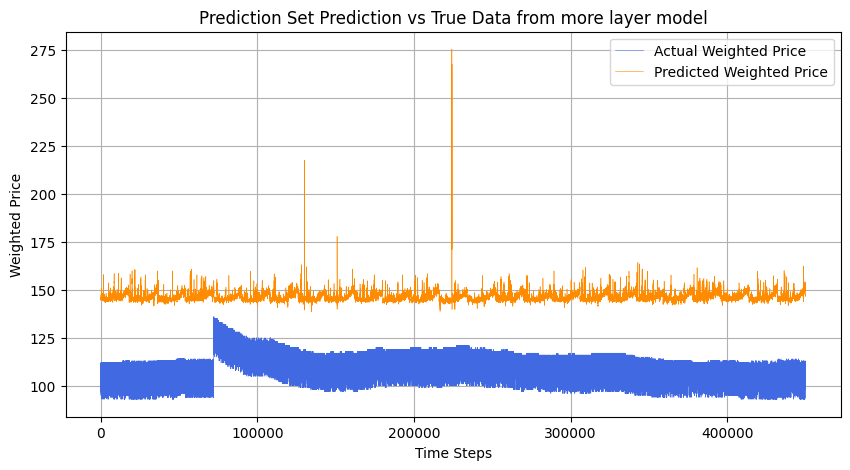

In [22]:
# 可视化预测结果与真实数据

# 100-200个点

plt.figure(figsize=(10, 5))
plt.plot(y_true_value_flattened , label='Actual Weighted Price', color='royalblue', linewidth=0.4)
plt.plot(y_pred_value_flatten, label='Predicted Weighted Price', color='darkorange', linewidth=0.4)
plt.title(f'Prediction Set Prediction vs True Data from more layer model')
plt.xlabel('Time Steps')
plt.ylabel('Weighted Price')
plt.legend()
plt.grid(True)

# 保存图像
plt.savefig('Pred_Predicted_vs_Actual_Weighted_Price.png')

plt.show()



In [24]:
# 验证集预测对照
# 加载最优模型
model_path = 'checkpoints/model-epoch011-val_loss0.0019.keras'

model = load_model(model_path)

y_valid_pred = model.predict(X_valid)

# 模型评估
mse_valid = mean_squared_error(y_valid, y_valid_pred)
rmse_valid = np.sqrt(mse_valid)

print("Mean Squared Error on Test Set:", mse_valid)
print("Root Mean Squared Error on Test Set:", rmse_valid)

# 横向合并 X_test和 y_pred（为了之后rescale）
combined_valid_pred = np.hstack((X_valid, y_valid_pred))

# rescale
combined_valid_pred_rescaled = scaler.inverse_transform(combined_valid_pred)

# 提取最后6列为rescale后的预测值
y_valid_pred_value = combined_valid_pred_rescaled[:, -6:]

# 将 y_pred_value 转换为一维数组
y_valid_pred_value_flatten = y_valid_pred_value.flatten()

# 将 y_pred_value 转换为 DataFrame 并保存
#pd.DataFrame(y_valid_pred_value_flatten).to_csv('y_valid_pred_value_flatten.csv')

# 打印预测值
#print("Flatten Predicted Values:", y_valid_pred_value_flatten)

# y_true_value 

y_valid_true_value = valid_Tapes_df

#print(y_valid_true_value)

# 将 DataFrame 转换为一维数组
y_valid_true_value_flattened = y_valid_true_value.values.flatten()

# 打印一维数组
#print("Flattened True Values:", y_valid_true_value_flattened)

# 可视化预测结果与真实数据

# 100-200个点





1875/1875 [==============================] - 116s 62ms/step
Mean Squared Error on Test Set: 0.0019212623541658268
Root Mean Squared Error on Test Set: 0.04383220681377823


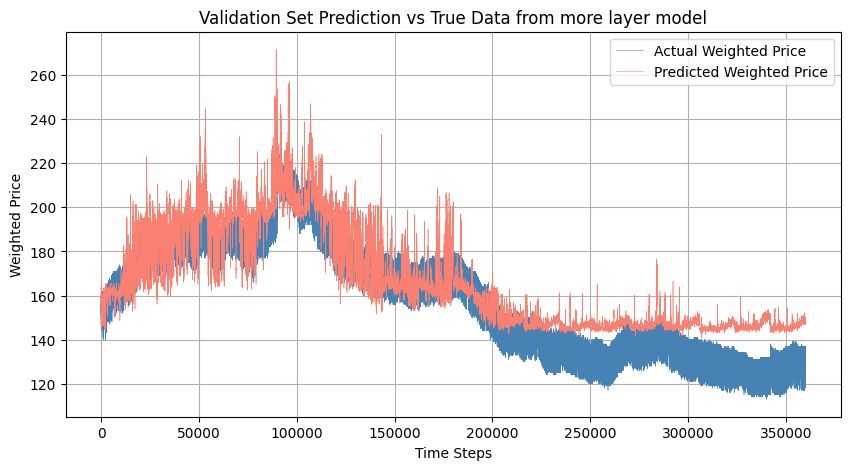

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(y_valid_true_value_flattened , label='Actual Weighted Price', color='steelblue', linewidth=0.4)
plt.plot(y_valid_pred_value_flatten, label='Predicted Weighted Price', color='salmon', linewidth=0.4)
plt.title(f'Validation Set Prediction vs True Data from more layer model')
plt.xlabel('Time Steps')
plt.ylabel('Weighted Price')
plt.legend()
plt.grid(True)

# 保存图像
plt.savefig('Valid_Predicted_vs_Actual_Weighted_Price.png')

plt.show()